The X-axis shows the percentage of votes gained, from 0.00 to 1.00. The Y-axis shows the total votes for that party across all polling stations with the specified percentage of votes for a particular party.

In [6]:
# Some initialization magic
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import collections

# Let's load up the data
import json
import codecs
import gzip

with gzip.GzipFile("scrapyproject/results.json.gz") as fin:
    fin = codecs.getreader('utf-8')(fin)
    tables = [json.loads(line) for line in fin]

In [7]:
HEADERS = [t for t in tables if t["data_type"] == "results_tik"][0]["row_headers"]
HEADERS

['Число избирателей, включенных в список избирателей',
 'Число избирательных бюллетеней, полученных участковой избирательной комиссией',
 'Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно',
 'Число избирательных бюллетеней, выданных в помещении для голосования в день голосования',
 'Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования',
 'Число погашенных избирательных бюллетеней',
 'Число избирательных бюллетеней в переносных ящиках для голосования',
 'Число бюллетеней в стационарных ящиках для голосования',
 'Число недействительных избирательных бюллетеней',
 'Число действительных избирательных бюллетеней',
 'Число утраченных избирательных бюллетеней',
 'Число избирательных бюллетеней, не учтенных при получении',
 'Бабурин Сергей Николаевич',
 'Грудинин Павел Николаевич',
 'Жириновский Владимир Вольфович',
 'Путин Владимир Владимирович',
 'Собчак Ксения Анатольевна',
 'Сурайкин Максим Александрович',
 'Титов Борис Юрь

In [9]:
a_table = [t for t in tables if t["data_type"] == "results_tik"][0]
CANDIDATE_IDX, CANDIDATES = zip(*[(i, j) for (i, j) in enumerate(a_table["row_headers"]) if i >= 12])
CANDIDATES

('Бабурин Сергей Николаевич',
 'Грудинин Павел Николаевич',
 'Жириновский Владимир Вольфович',
 'Путин Владимир Владимирович',
 'Собчак Ксения Анатольевна',
 'Сурайкин Максим Александрович',
 'Титов Борис Юрьевич',
 'Явлинский Григорий Алексеевич')

In [12]:
import scipy.signal

eligible_voters_idx = HEADERS.index('Число избирателей, включенных в список избирателей')
valid_ballots_idx = HEADERS.index('Число действительных избирательных бюллетеней')


def station_generator(selected_tables=tables):
    """Yield the polling stations (UIK) along with the attributes that we will be plotting."""
    for table in [t for t in selected_tables if t["data_type"] == "results_uik"]:
        eligible_voters = table["data"][eligible_voters_idx]
        valid_ballots = table["data"][valid_ballots_idx]

        # Calculate the turnout as the number of valid ballots out of the total number of voters for that station
        # One-based indexing because the first column is the total across all stations.
        #
        # The votes array for each station contain the number of votes counted for each party, in order of PARTIES.
        # The fraction array contains the proportion of votes for each party, in the same order.
        for st_idx, st_name in enumerate(table["column_headers"]):
            if st_idx == 0:
                # skip the total across all stations
                continue
            
            try:
                station = {
                    "region": table["region"],
                    "territory": table["territory"],
                    "local_ik": st_name,
                    "fraction": [],
                    "votes": [],
                    "turnout": valid_ballots[st_idx] / eligible_voters[st_idx]
                }
            
                for candidate_idx in CANDIDATE_IDX:
                    raw_votes = table["data"][candidate_idx][st_idx]
                    station["votes"].append(raw_votes)
                    station["fraction"].append(raw_votes / valid_ballots[st_idx])

                yield station
            except ZeroDivisionError:
                # TODO: why no valid ballots at this station?
                pass

        
def round_nearest(x, a=0.002):
    """Round the x-value to the nearest a-value."""
    # http://stackoverflow.com/questions/28425705/python-rounding-a-floating-point-number-to-nearest-0-05
    return round(x / a) * a


def bin_by(stations, key_function, round_function=round_nearest):
    """Bin each polling station by the turnout at the station."""
    bins = collections.defaultdict(list)
    for station in stations:
        bins[round_function(key_function(station))].append(station)
    return sorted(bins.items())

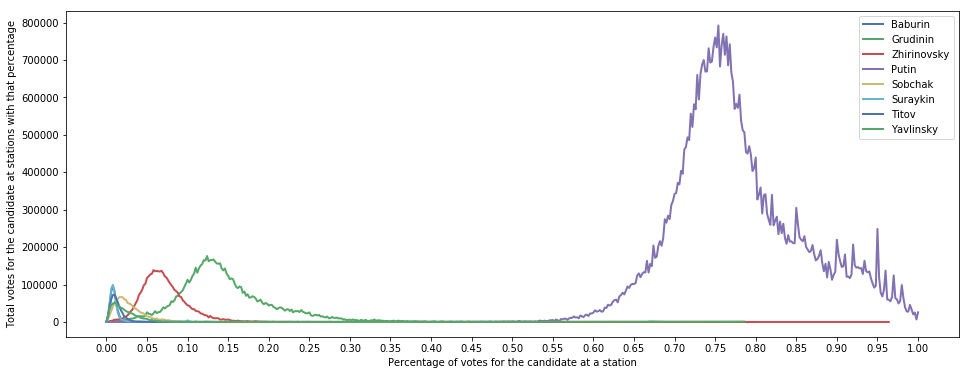

In [17]:
plt.style.use('seaborn-deep')


def plot(candidate_name, ascii_name, color=None, linewidth=2, data_type="federal"):
    stations = list(station_generator())
    assert stations        
    party_idx = CANDIDATES.index(candidate_name)
    bins = bin_by(stations, lambda station: station["fraction"][party_idx])
    x = [val for (val, _) in bins]
    y = [sum(st["votes"][party_idx] for st in stations) for (_, stations) in bins]
    plt.plot(x, y, linewidth=linewidth, label=ascii_name, color=color)

plt.figure(figsize=(16, 6))


plot('Бабурин Сергей Николаевич', 'Baburin')
plot('Грудинин Павел Николаевич', 'Grudinin')
plot('Жириновский Владимир Вольфович', 'Zhirinovsky')
plot('Путин Владимир Владимирович', "Putin")
plot('Собчак Ксения Анатольевна', 'Sobchak')
plot('Сурайкин Максим Александрович', 'Suraykin')
plot('Титов Борис Юрьевич', 'Titov')
plot('Явлинский Григорий Алексеевич', 'Yavlinsky')

plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Total votes for the candidate at stations with that percentage")
plt.xlabel("Percentage of votes for the candidate at a station")

plt.legend()

print()